In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.optimize import minimize

df = pd.read_csv('Task 3 and 4_Loan_Data.csv')

In [9]:
# Check dataset structure
print(df.head())

# Ensure column names
fico_column = 'fico_score' # Change if column name is different
default_column = "default"  # Change if column name is different

# Extract FICO scores and default labels
fico_scores = df[fico_column].values
defaults = df[default_column].values

   customer_id  credit_lines_outstanding  loan_amt_outstanding  \
0      8153374                         0           5221.545193   
1      7442532                         5           1958.928726   
2      2256073                         0           3363.009259   
3      4885975                         0           4766.648001   
4      4700614                         1           1345.827718   

   total_debt_outstanding       income  years_employed  fico_score  default  
0             3915.471226  78039.38546               5         605        0  
1             8228.752520  26648.43525               2         572        1  
2             2027.830850  65866.71246               4         602        0  
3             2501.730397  74356.88347               5         612        0  
4             1768.826187  23448.32631               6         631        0  


In [10]:
# 1. K-MEANS CLUSTERING TO FIND BUCKETS (Minimizing MSE)
def kmeans_buckets(fico_scores, num_buckets=5):
    fico_scores = fico_scores.reshape(-1, 1)  # Reshape for KMeans
    kmeans = KMeans(n_clusters=num_buckets, random_state=42, n_init=10)
    kmeans.fit(fico_scores)
    
    # Get cluster centers and sort them
    bucket_boundaries = np.sort(kmeans.cluster_centers_.flatten())
    return bucket_boundaries


In [11]:
# Compute optimal bucket boundaries using K-Means
kmeans_boundaries = kmeans_buckets(fico_scores, num_buckets=5)
print(f"\nK-Means Bucket Boundaries: {kmeans_boundaries}")



K-Means Bucket Boundaries: [525.30022573 585.14194722 631.83004349 677.78359909 734.87780356]


In [12]:
# 2. LOG-LIKELIHOOD MAXIMIZATION FOR BUCKETS
def log_likelihood_buckets(fico_scores, defaults, num_buckets=5):
    """
    Optimize FICO score buckets by maximizing log-likelihood.
    """
    def neg_log_likelihood(boundaries):
        """
        Compute the negative log-likelihood for given bucket boundaries.
        """
        boundaries = np.sort(boundaries)  # Ensure sorted boundaries
        bin_indices = np.digitize(fico_scores, bins=boundaries, right=True)

        log_likelihood = 0
        for i in range(len(boundaries) - 1):
            bin_mask = (bin_indices == i)
            ni = np.sum(bin_mask)  # Number of records in bucket
            ki = np.sum(defaults[bin_mask])  # Number of defaults

            if ni > 0:
                pi = (ki / ni) if ni > 0 else 0.01  # Probability of default
                log_likelihood += ki * np.log(pi + 1e-6) + (ni - ki) * np.log(1 - pi + 1e-6)

        return -log_likelihood  # Negative log-likelihood for minimization

    # Initial boundary guesses (evenly spaced)
    initial_boundaries = np.linspace(min(fico_scores), max(fico_scores), num_buckets + 1)[1:-1]

    # Optimize boundaries to maximize log-likelihood
    result = minimize(neg_log_likelihood, initial_boundaries, method="Powell")

    optimized_boundaries = np.sort(result.x)
    return optimized_boundaries

In [13]:
# Compute optimal bucket boundaries using Log-Likelihood Maximization
log_likelihood_boundaries = log_likelihood_buckets(fico_scores, defaults, num_buckets=5)
print(f"\nLog-Likelihood Optimized Bucket Boundaries: {log_likelihood_boundaries}")



Log-Likelihood Optimized Bucket Boundaries: [-5299.10371295   181.86297512   268.48478383   761.6       ]


In [14]:
# --------- Assign FICO Scores to Buckets ---------
def assign_buckets(fico_scores, boundaries):
    return np.digitize(fico_scores, bins=boundaries, right=True)

df['KMeans_Bucket'] = assign_buckets(df[fico_column].values, kmeans_boundaries)
df['LogLikelihood_Bucket'] = assign_buckets(df[fico_column].values, log_likelihood_boundaries)


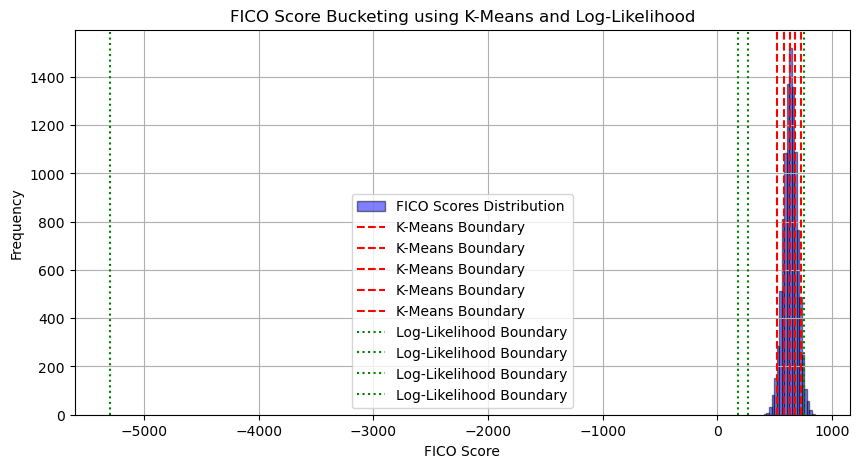

In [16]:
# VISUALIZATION
plt.figure(figsize=(10, 5))

plt.hist(fico_scores, bins=20, alpha=0.5, label="FICO Scores Distribution", color="blue", edgecolor="black")
for boundary in kmeans_boundaries:
    plt.axvline(boundary, color="red", linestyle="dashed", label="K-Means Boundary")

for boundary in log_likelihood_boundaries:
    plt.axvline(boundary, color="green", linestyle="dotted", label="Log-Likelihood Boundary")

plt.xlabel("FICO Score")
plt.ylabel("Frequency")
plt.title("FICO Score Bucketing using K-Means and Log-Likelihood")
plt.legend()
plt.grid()
plt.show()